In [1]:
library(BiocManager)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ArchR)
library(ggplot2)
library(TFBSTools)
library(Seurat)
library(ggplot2)
library(dplyr)
library(harmony)
#library(SeuratData)
library(BSgenome.Hsapiens.UCSC.hg38)
# library(JASPAR2018)
library(edgeR)

library(ArchR)
data("geneAnnoHg38")
data("genomeAnnoHg38")
geneAnno <- geneAnnoHg38
genomeAnno <- genomeAnnoHg38
addArchRThreads(24)


Bioconductor version '3.16' is out-of-date; the current release version '3.17'
  is available with R version '4.3'; see https://bioconductor.org/install

Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


L

In [2]:
library(Matrix)
library(SummarizedExperiment)
#library(tidyverse)
library(uwot)
library(edgeR)
library(FNN)
library(matrixStats)
library(Rcpp)
set.seed(1)

In [3]:
get_up_enhancer_peakset <- function(comma_sep_data_in) {
    comma_sep_data <- strsplit(comma_sep_data_in, ",")
    comma_sep_data <- matrix(unlist(comma_sep_data), ncol = 5, byrow = TRUE)
    comma_sep_data <- data.frame(comma_sep_data)
    colnames(comma_sep_data) <- c("seqnames", "tmp", "start" ,"tmp2", "end")
    comma_sep_data[c("seqnames","start","end")]
    
    }

In [4]:
get_subtype_marking <- function(name) {
    cleaned_text <- tolower(gsub(":.*", "", name))
    subtype <- cleaned_text
    if (grepl("lum", cleaned_text)) {
        subtype <- "Lum"
    }
    if (grepl("basal", cleaned_text)) {
        subtype <- "BASAL"
    }
    if (grepl("her2", cleaned_text)) {
        subtype <- "HER2"
    }
    subtype
}

get_sample_marking <- function(name) {
    cleaned_text <- tolower(gsub("_cancer", "", name))
    cleaned_text <- tolower(gsub("_control", "", cleaned_text))
    cleaned_text
}


get_cancer_marking <- function(name) {
    subtype <- ""
    if (grepl("_control", name)) {
        subtype <- "Control"
    }
    if (grepl("_cancer", name)) {
        subtype <- "Cancer"
    }
    subtype
}

In [5]:
get_pca_plot <- function(mat_sample_by_peak,samplename,selection,minsamples) {
    
    rownames_toconsider <- c()
    
    print(selection)
    if (selection == "cancer") {
        rownames_toconsider <- c()
        for (nm in rownames(mat_sample_by_peak)) {
            if (grepl("_cancer",nm)){
                rownames_toconsider <- append(rownames_toconsider,nm)
                }
            }
        }
        
    else if (selection == "control") {
        for (nm in rownames(mat_sample_by_peak)) {
            if (grepl("_control",nm)){
                rownames_toconsider <- append(rownames_toconsider,nm)
                }
            }
        }
        
    else if (selection == "cancer_and_control") {
        rownames_toconsider <- rownames(mat_sample_by_peak)
    }

    
    mat_sample_by_peak_subset <- mat_sample_by_peak[rownames_toconsider,]
    mat_sample_by_peak_subset<- mat_sample_by_peak_subset[,colSums(mat_sample_by_peak_subset) > minsamples]
    print(paste0("after subsetting ",dim(mat_sample_by_peak_subset)))
    
    set.seed(94404)
    pca_obj <- prcomp(mat_sample_by_peak_subset)
    mat_sample_by_peak_pca <- predict(pca_obj, mat_sample_by_peak_subset)
    print(dim(mat_sample_by_peak_pca))
    print(summary(pca_obj))
    
    
    subtypes <- c()
    for (name in rownames(mat_sample_by_peak_subset)) {
        cluster_name <- get_subtype_marking(name)
        subtypes <- append(subtypes,cluster_name)
    }
    print(subtypes)

    indicators <- c()
    for (name in rownames(mat_sample_by_peak_subset)) {
        cluster_name <- get_cancer_marking(name)
        indicators <- append(indicators,cluster_name)
    }
    print(indicators)

    sample_names <- c()
    for (name in rownames(mat_sample_by_peak_subset)) {
        cluster_name <- get_sample_marking(name)
        sample_names <- append(sample_names,cluster_name)
    }
    print(sample_names)
    
    
    df_pca <- data.frame(
        x = mat_sample_by_peak_pca[,1],
        y = mat_sample_by_peak_pca[,2],
        subtype = subtypes,
        cancer_control=indicators,
        sample=sample_names
        )
    df_pca
    
    title <- paste0(samplename,"_",selection,"_",minsamples)
    print(title)
    picture <- ggplot(df_pca,aes(x,y,colour=subtype,shape=cancer_control)) + 
                geom_point() + 
                xlab("PCA Dimension 1") + 
                ylab("PCA Dimension 2") + theme_bw() + theme(panel.grid.major = element_blank(),
                                                panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) + ggtitle(title)

    fig_save_path <- paste0("/illumina/scratch/deep_learning/akumar22/TCGA/cancer_v_control/pdf_figures_pca/",title,".pdf")
    ggsave(picture, file=fig_save_path, useDingbats=F)
    
    ## save the pca
    df_pca_save_path <- paste0("/illumina/scratch/deep_learning/akumar22/TCGA/cancer_v_control/pdf_figures_pca/",title,"_df_pca.rds")
    saveRDS(df_pca,df_pca_save_path)
    
    ## save the pca
    pca_save_path <- paste0("/illumina/scratch/deep_learning/akumar22/TCGA/cancer_v_control/pdf_figures_pca/",title,"_pca.rds")
    saveRDS(pca_obj,pca_save_path)
    picture
}

### create sample by differential peaks matrix

In [6]:
sample_names <- c("brca","brca_noher2","luad","blca")

sample_enhancer_files <- c("/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/ArchR_Projects/Cancer_controls_combined/BRCA_case_control_ArchR_NEW/BRCA_differential_enhancers_obj.rds",
                           "/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/ArchR_Projects/Cancer_controls_combined/BRCA_case_control_ArchR_NEW/BRCA_differential_enhancers_obj.rds",
                           "/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/ArchR_Projects/Cancer_controls_combined/LUAD_cancer_control_fetal_Adult/LUAD_differential_enhancers_obj.rds",
                           "/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/ArchR_Projects/Cancer_controls_combined/BLCA_cancer_control_Adult/BLCA_differential_enhancers_obj.rds")



In [7]:
sample_index <- 1 ### 1 is for brca, and so on

In [8]:
sample_name <- sample_names[sample_index]
print(sample_name)
enhancer_diff <- sample_enhancer_files[sample_index]
print(enhancer_diff)
enhancer_df <- readRDS(enhancer_diff)
print(names(enhancer_df))
print(length(names(enhancer_df)))
num_rows <- length(rownames(enhancer_df[[names(enhancer_df)[1]]]))
print(num_rows)

[1] "brca"
[1] "/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/ArchR_Projects/Cancer_controls_combined/BRCA_case_control_ArchR_NEW/BRCA_differential_enhancers_obj.rds"
 [1] "LumA_1: 08499A64_3FD8_4E62_AF08_3C66AF93CAE7" 
 [2] "LumB_4: 14AD76EE_12F9_40B3_8DCD_4A256E02CF8D" 
 [3] "HER2_4: 1D939DC3_EF0C_40BF_BC60_8C5D46345265" 
 [4] "BASAL1: 2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E" 
 [5] "LumA_2: 5C54B79C_DA02_4B22_9FC2_3D61BFFC5559" 
 [6] "BASAL2: 7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170" 
 [7] "HER2_1: 8D1E6006_85CB_484A_8B5C_30766D90137B" 
 [8] "HER2_1a: 8D1E6006_85CB_484A_8B5C_30766D90137B"
 [9] "HER2_3: 94AF19F0_1F2A_41EC_8CB6_96C76227811F" 
[10] "LumA_3: A91AADEA_8299_46D9_A250_76896D690AFD" 
[11] "HER2_2: C147AAD5_A8F1_41D5_8709_21820BE50902" 
[12] "LumB_5: C9C8D426_A3FD_4455_89A9_768BC01D66A9" 
[13] "BASAL3: CB96A542_7AC1_4FEC_A5D2_458D8EEDC6C4" 
[14] "BASAL5: CC102C17_C1CA_427A_8C7D_D3E79748A0CD" 
[15] "BASAL4: DD69EDE9_142D_46E2_AA06_58D07D3230FB" 
[1] 15
[1] 506237


In [9]:
if (sample_name == "blca") {
    blca_keys <- c("1067A79F-15D6-4D64-BBC3-268BE15434A1",
    "CC5A9968-1F7F-4698-B483-1D426BF00AE3",
    "3E71B261-9C29-4025-973A-3901B0826643",
    "CC57A8ED-A5DB-4ADA-A038-ABE5AA7A6A2B",
    "6E1FF9EA-8875-439E-AF5A-A7B7DDFB247C",
    "795D3511-E7DB-456E-9D80-4EE5B50B66E1",
    "C1820F13-D6CF-4BCF-A842-A01D6E6C61EB",
    "761A45CF-D6D2-46EA-93EC-5238A95517B8",
    "6728BCB4-B161-41DD-BF27-16000A1A9A94")


    blca_values <- c("ARIDA1A_WT",
    "ARIDA1Amut",
    "ARIDA1Amut",
    "ARIDA1A_WT",
    "FGD4",
    "ARIDA1A_WT",
    "ARIDA1Amut",
    "ARIDA1Amut",
    "ARIDA1A_WT")

    blca_name_type_dict <- setNames(blca_values, blca_keys)
    blca_name_type_dict

    newnames <- c()
    for (name in names(enhancer_df)) {
        cleaned_text <- gsub(".*: ", "", name)
        cleaned_text <- gsub("_", "-", cleaned_text)
        print(cleaned_text)
        blca_type_text <- unname(blca_name_type_dict[cleaned_text])
        print(blca_type_text)
        newnames <- append(newnames,paste0(blca_type_text,": ",gsub(".*: ", "", name)))
    }

    names(enhancer_df) <- newnames
    names(enhancer_df)
}

In [10]:
### binary
df<-data.frame(matrix(nrow=num_rows,ncol=0))
for (name in names(enhancer_df)) {
    
    print(name)
    en1 <- enhancer_df[[name]]
    head(en1)
    
    if (name %in% c('BASAL5: CC102C17_C1CA_427A_8C7D_D3E79748A0CD')) {
        next
    }
    
        ### comment this out to include HER2 samples
    if (sample_name == "brca_noher2") {
        if (get_subtype_marking(name) %in% c("HER2")) {
            next
        }
    }

    ### comment this out to exclude cancer samples
    en1$up_values <- 1
    en1$up_values[en1$FDR >= 0.05] <- 0
    en1$up_values[en1$log2FC <= 1] <- 0
    print(paste0("sanity check ",sum(en1$up_values != 0) == sum(en1$type == "up-regulated")))
    print(sum(en1$type == "up-regulated"))
    df[paste0(name,"_cancer")] <- abs(en1$up_values)
    
    ### comment this out to exclude control samples
    en1$down_values <- 1
    en1$down_values[en1$FDR >= 0.05] <- 0
    en1$down_values[en1$log2FC >= -1] <- 0
    print(paste0("sanity check ",sum(en1$down_values != 0) == sum(en1$type == "do-regulated")))
    df[paste0(name,"_control")] <- abs(en1$down_values)

    }

mat_sample_by_peak <- t(data.matrix(df))
dim(mat_sample_by_peak)
colnames(mat_sample_by_peak) <- rownames(en1)



[1] "LumA_1: 08499A64_3FD8_4E62_AF08_3C66AF93CAE7"
[1] "sanity check TRUE"
[1] 37700
[1] "sanity check TRUE"
[1] "LumB_4: 14AD76EE_12F9_40B3_8DCD_4A256E02CF8D"
[1] "sanity check TRUE"
[1] 46421
[1] "sanity check TRUE"
[1] "HER2_4: 1D939DC3_EF0C_40BF_BC60_8C5D46345265"
[1] "sanity check TRUE"
[1] 48111
[1] "sanity check TRUE"
[1] "BASAL1: 2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E"
[1] "sanity check TRUE"
[1] 36370
[1] "sanity check TRUE"
[1] "LumA_2: 5C54B79C_DA02_4B22_9FC2_3D61BFFC5559"
[1] "sanity check TRUE"
[1] 48187
[1] "sanity check TRUE"
[1] "BASAL2: 7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170"
[1] "sanity check TRUE"
[1] 71372
[1] "sanity check TRUE"
[1] "HER2_1: 8D1E6006_85CB_484A_8B5C_30766D90137B"
[1] "sanity check TRUE"
[1] 63991
[1] "sanity check TRUE"
[1] "HER2_1a: 8D1E6006_85CB_484A_8B5C_30766D90137B"
[1] "sanity check TRUE"
[1] 55281
[1] "sanity check TRUE"
[1] "HER2_3: 94AF19F0_1F2A_41EC_8CB6_96C76227811F"
[1] "sanity check TRUE"
[1] 47221
[1] "sanity check TRUE"
[1] "LumA_3: A91AA

[1]     28 506237

In [ ]:
get_pca_plot(mat_sample_by_peak,samplename=sample_name,selection="cancer",minsamples=2)

[1] "cancer_and_control"
[1] "after subsetting 28"     "after subsetting 118189"
[1] 28 28
Importance of components:
                          PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     69.357 45.60105 35.86351 32.88602 32.24193 30.08396
Proportion of Variance  0.223  0.09638  0.05962  0.05013  0.04818  0.04195
Cumulative Proportion   0.223  0.31935  0.37896  0.42909  0.47727  0.51922
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     28.97348 27.05740 26.53555 26.29228 26.01183 24.27335
Proportion of Variance  0.03891  0.03393  0.03264  0.03204  0.03136  0.02731
Cumulative Proportion   0.55813  0.59206  0.62470  0.65674  0.68810  0.71541
                           PC13     PC14     PC15     PC16     PC17     PC18
Standard deviation     23.62965 23.34116 23.09993 22.28173 21.77871 21.25828
Proportion of Variance  0.02588  0.02525  0.02473  0.02301  0.02198  0.02095
Cumulative Proportion   0.74129  0.76655  0.

Saving 6.67 x 6.67 in image


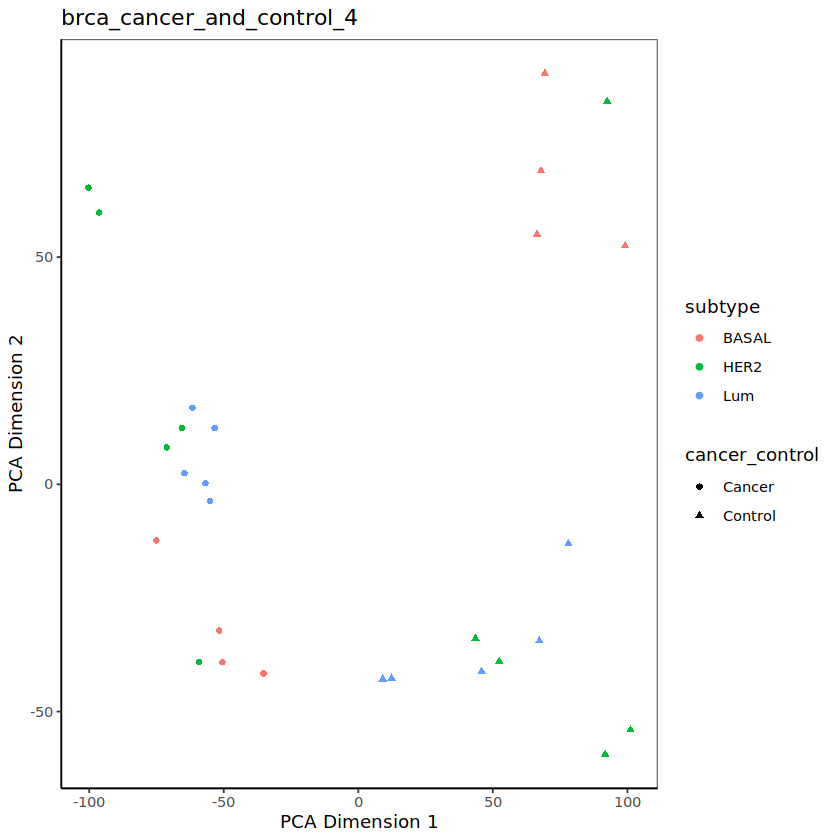

In [11]:
get_pca_plot(mat_sample_by_peak,samplename=sample_name,selection="cancer_and_control",minsamples=4)

[1] "cancer_and_control"
[1] "after subsetting 28"    "after subsetting 28919"
[1] 28 28
Importance of components:
                           PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     46.7531 24.78884 19.58951 17.20248 15.22222 14.82278
Proportion of Variance  0.3362  0.09451  0.05902  0.04552  0.03564  0.03379
Cumulative Proportion   0.3362  0.43072  0.48974  0.53526  0.57090  0.60469
                            PC7      PC8     PC9     PC10     PC11     PC12
Standard deviation     14.48979 14.19480 13.8491 13.54570 13.10544 12.88203
Proportion of Variance  0.03229  0.03099  0.0295  0.02822  0.02642  0.02552
Cumulative Proportion   0.63698  0.66797  0.6975  0.72570  0.75211  0.77764
                           PC13     PC14     PC15    PC16    PC17     PC18
Standard deviation     12.68723 12.27947 11.83039 10.9361 10.5742 10.22885
Proportion of Variance  0.02476  0.02319  0.02153  0.0184  0.0172  0.01609
Cumulative Proportion   0.80239  0.82559  0.84711  0

Saving 6.67 x 6.67 in image


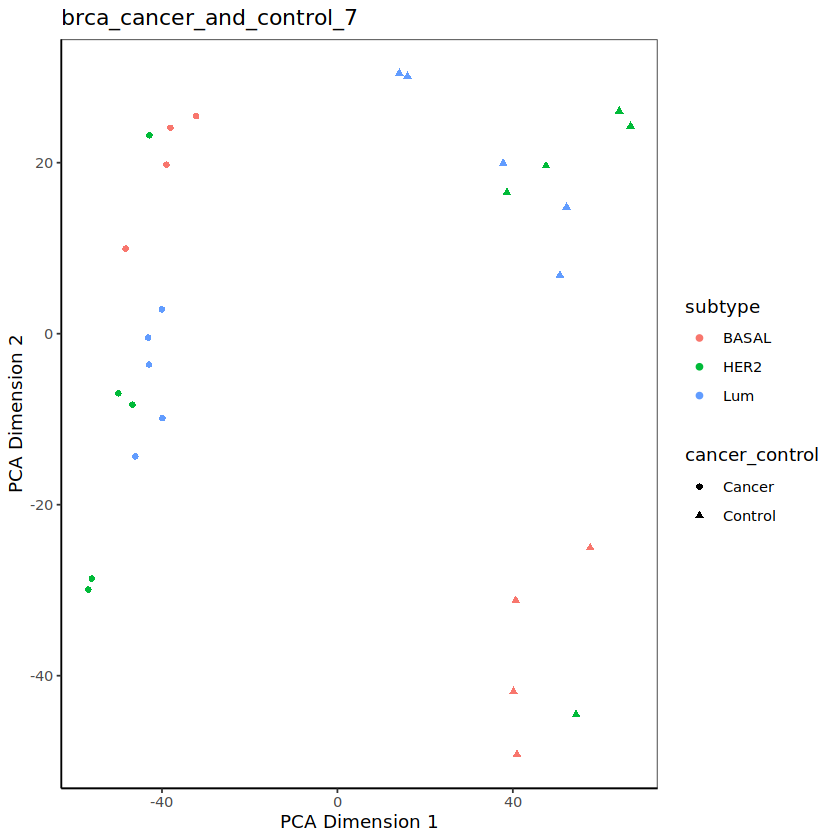

In [12]:
get_pca_plot(mat_sample_by_peak,samplename=sample_name,selection="cancer_and_control",minsamples=7)

### differential enhancers > and <= samples

In [ ]:
rownames_toconsider_cancer <- c()
rownames_toconsider_control <- c()
for (nm in rownames(mat_sample_by_peak)) {
    if (grepl("_cancer",nm)){
        rownames_toconsider_cancer <- append(rownames_toconsider_cancer,nm)
        }
    if (grepl("_control",nm)){
        rownames_toconsider_control <- append(rownames_toconsider_control,nm)
        }
    }
print(rownames_toconsider_cancer)
print("")
print(rownames_toconsider_control)

In [ ]:
"""

BRCA
starts <- c(3,4)
ends <- c(4,15)

LUAD
starts <- c(2,3)
ends <- c(3,8)

BLCA
starts <- c(2,3,4)
ends   <- c(3,4,10)



In [ ]:
# starts <- c(2,3,4)
# ends   <- c(3,4,10)

# starts <- c(2,3)
# ends <- c(3,8)

# starts <- c(3,4)
# ends <- c(4,15)

mat_sample_by_peak_cancer <- mat_sample_by_peak[rownames_toconsider_cancer,]
for (idx in seq(1,length(starts)))
{
    i <- starts[idx]
    j <- ends[idx]
    print(paste0(i," ",j))
    selected_cols <- colSums(mat_sample_by_peak_cancer) >= i & colSums(mat_sample_by_peak_cancer) < j
    mat_sample_by_peak_sample <- mat_sample_by_peak[,selected_cols]
    print(dim(mat_sample_by_peak_sample))
    differential_peakset <- get_up_enhancer_peakset(colnames(mat_sample_by_peak_sample))
    print(dim(differential_peakset))
    experiment_name <- paste0(sample_name,"_cancer_atleast_",i,"_lt_",j)
    write.csv(differential_peakset, paste0("/illumina/scratch/deep_learning/akumar22/TCGA/cancer_v_control/differential_enhancers/",experiment_name,".csv"))
}


mat_sample_by_peak_control <- mat_sample_by_peak[rownames_toconsider_control,]
for (idx in seq(1,length(starts)))
{
    i <- starts[idx]
    j <- ends[idx]
    print(paste0(i," ",j))
    selected_cols <- colSums(mat_sample_by_peak_control) >= i & colSums(mat_sample_by_peak_control) < j
    mat_sample_by_peak_sample <- mat_sample_by_peak[,selected_cols]
    print(dim(mat_sample_by_peak_sample))
    differential_peakset <- get_up_enhancer_peakset(colnames(mat_sample_by_peak_sample))
    print(dim(differential_peakset))
    experiment_name <- paste0(sample_name,"_control_atleast_",i,"_lt_",j)
    write.csv(differential_peakset, paste0("/illumina/scratch/deep_learning/akumar22/TCGA/cancer_v_control/differential_enhancers/",experiment_name,".csv"))
}